In [1]:
import sklearn
import requests
import ujson as json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import random

## Get the data

Today's data contains charters, manifestos and working documents all discussing some variations of "ethical AI". Some of them originate from companies (i.e. Google, Microsoft...), others from non-profits (i.e. the Council of Europe), others from (supra-) national institutions (European Parliament, House of Lords...), and others from citizen groups (#Free AI...). They all have in common that they discuss some variant of AI ethics, and are (at least partly) prescriptive: they go beyond describing the state of things and provide recommendations. This data has been published as a coherent corpus, called [MapAIE](http://mapaie.telecom-paris.fr) (Mapping AI Ethics).

In [2]:
json_data = requests.get("http://mapaie.telecom-paris.fr/mapaie.json").content

In [3]:
data = json.loads(json_data)

In [4]:
len(data)

378

## Basic exploration

Each document is structured as a dictionary, containing its `id` (an integer from $0$ to $n-1$), its `title`, and its `contents`. 

In [5]:
data[0]

{'id': '0',
 'title': 'Intel Recommends Public Policy Principles for Artificial Intelligence',
 'contents': "\n\tIntel Recommends Public Policy Principles for Artificial Intelligence - Intel Community\n      \nSearch\n     Browse                       Support Community   About   Developer Software Forums    Developer Software Forums   Software Development Tools   Toolkits & SDKs   Software Development Topics   Software Development Technologies   Intel® DevCloud   oneAPI Registration, Download, Licensing and Installation   GPU Compute Software   Intel® Developer Cloud   Edge Developer Toolbox   Software Archive       Product Support Forums    Product Support Forums   FPGA   Memory & Storage   Visual Computing   Embedded Products   Graphics   Processors   Wireless   Ethernet Products   Server Products   Intel vPro® Platform   Intel® Enpirion® Power Solutions   Intel® Unison™ App   Intel® QuickAssist Technology (Intel® QAT)   Intel® Trusted Execution Technology (Intel® TXT)   Thunderbolt™

## Topic modelling with Latent Dirichlet Allocation

Now that we have a basic understanding of the data, the goal is to get familiar with the LDA method and get a decent idea of the topics in our dataset.

In [6]:
n_features = 1000
n_components = 15
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

X = [x["contents"] for x in data]
# Using the sklearn CountVectorizer -- you can replace it with Tfidfvectorizer and see the differences :)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
vectorizedX = tf_vectorizer.fit_transform(X)
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(vectorizedX)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=15, random_state=0)

Let us display the top words per topic to help interpretation.

In [7]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: court data odr online adm use decision law case access legal article systems automated administrative decisions justice parties public used
Topic #1: data health ai use care technologies biometric systems used rights recognition protection eu technology identification 2020 public patient law ethical
Topic #2: ai https data intelligence use www artificial technology 2019 research standards 2021 systems government public 2020 org 2018 com development
Topic #3: gs color op gcss base var font important background margin size border width padding grid height display 1fr 100 content
Topic #4: und ki der die von des training data ai adm digital oecd es 2019 systems decision rights 2020 eu automated
Topic #5: ai data eu european robotics systems ethics use robots commission ethical human development intelligence research union artificial legal digital public
Topic #6: ai learning machine data systems intelligence artificial model 2017 research https 10 2019 mode

Using methods from the lecture slides, annotate one (arbitrary) document with the topics associated to each word. You can simply write the contents as "word [topic] word2 [topic2] etc.". You can get the values for $<\beta_{k,v}>$ with `exp_dirichlet_component_`.

In [14]:
# Write code here
import numpy as np

logbeta=lda.exp_dirichlet_component_

i=random.randint(0, len(data))
document=data[i]
text=document["contents"]

words = []
current_word = ""

for char in text.lower():  
    if char.isalpha(): 
        current_word += char  
    elif current_word: 
        words.append(current_word)  
        current_word = ""  

if current_word:
    words.append(current_word)

for word in words:
    if word in tf_feature_names:
        word_index=np.where(tf_feature_names==word)
        topic=np.argmax(logbeta[:,word_index])
        print(word + '[topic #' + str(topic) + ']') 
    else:
        print(word + '[not topic]')



december[topic #10]
cepej[not topic]
rev[not topic]
european[topic #10]
commission[topic #5]
for[not topic]
the[not topic]
effic[not topic]
iency[not topic]
of[not topic]
justice[topic #0]
cepej[not topic]
possible[topic #7]
introduction[topic #14]
of[not topic]
a[not topic]
mechanism[not topic]
for[not topic]
certif[not topic]
ying[not topic]
artificial[topic #14]
intelligence[topic #14]
tools[topic #10]
and[not topic]
services[topic #9]
in[not topic]
the[not topic]
sphere[not topic]
of[not topic]
justice[topic #0]
and[not topic]
the[not topic]
judiciary[not topic]
feasibility[not topic]
s[not topic]
tudy[not topic]
in[not topic]
december[topic #10]
the[not topic]
european[topic #10]
commission[topic #5]
for[not topic]
the[not topic]
efficiency[topic #0]
of[not topic]
justice[topic #0]
cepej[not topic]
adopt[not topic]
ed[topic #9]
the[not topic]
ethical[topic #5]
charter[topic #7]
on[not topic]
the[not topic]
use[topic #1]
of[not topic]
artificial[topic #14]
intelligence[topic #14]
i

Given an arbitrary document, can you find the most similar documents (see the formula from lectures slides)?

In [36]:
# Write code here
i=random.randint(0, len(data))

document_topic_probs = lda.transform(vectorizedX) 

distdoc={}
for j in range(len(data)):
    if j!=i:
        cpt=0
        for k in range(n_components):
            cpt+=((document_topic_probs[i][k])**1/2 - (document_topic_probs[j][k])**1/2)**2
        distdoc[j]=float(cpt)

best_similarity=sorted(distdoc.items(), key=lambda x: x[1])
print('data numero : ' + str(i))

print('les 5 documents les plus similaires sont : ')
for i in range(5):
    print( data[best_similarity[i][0]]['title'] + ' : data numéro ' + str(best_similarity[i][0]) + ' avec une distance de : ' + str(best_similarity[i][1]))

        



data numero : 88
les 5 documents les plus similaires sont : 
Policy and investment recommendations for trustworthy Artificial Intelligence : data numéro 123 avec une distance de : 0.003938115747461234
Declaration on AI in the Nordic-Baltic Region : data numéro 254 avec une distance de : 0.011938690945620152
Global competition and convergence of AI Law : data numéro 370 avec une distance de : 0.01524974301328412
Coordinated plan on AI : data numéro 116 avec une distance de : 0.015252315965144862
Artificial Intelligence for Europe : data numéro 112 avec une distance de : 0.017295807611638108


In [42]:
#Pour le fun

nmf = NMF(n_components=2, random_state=0)
doc_embeddings_2D = nmf.fit_transform(document_topic_probs)

main_topic = np.argmax(document_topic_probs, axis=1)

for i in range (len(doc_embeddings_2D)):
    topic = main_topic[i]

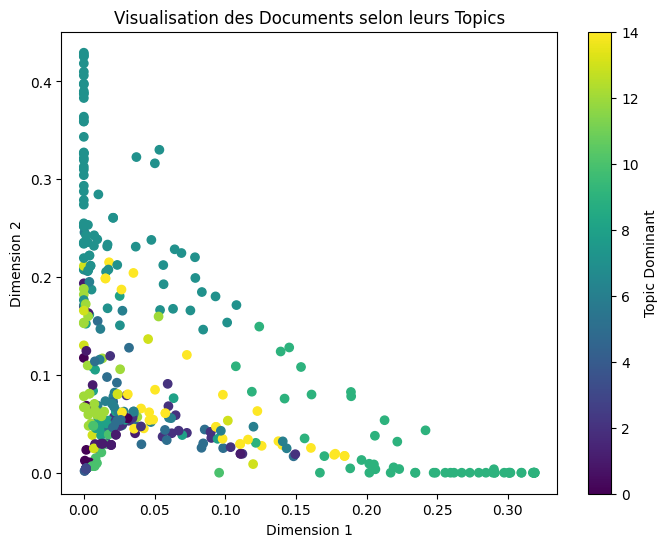

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(doc_embeddings_2D[:, 0], doc_embeddings_2D[:, 1], c=main_topic, cmap="viridis")
plt.colorbar(scatter, label="Topic Dominant")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Visualisation des Documents selon leurs Topics")
plt.show()


On observe certains cluster comme pour les documents avec comment topic principal 9(en bas à droite) et de même avec ceux de topic principal 7 (en haut à gauche), en bas à gauche c'est plus mélangé, mais on y voit quand même quelques regroupements (vert clair: 12 par exemple)

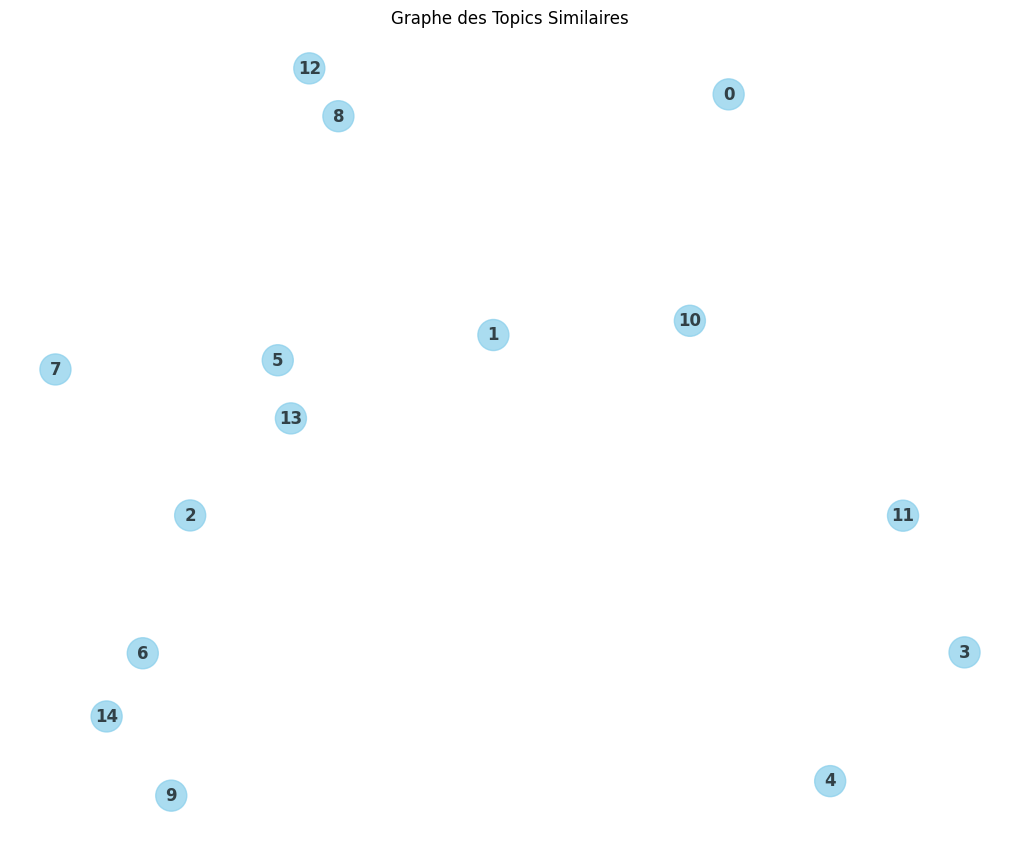

In [47]:
#Partie faite avec l'aide d'IA générative juste pour essayer de visualiser, cependant la visualisation n'est pas très concluente.


import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

num_topics = 15  # Par exemple, si tu as 15 topics
threshold = 0.8  # Seuil de similarité pour considérer deux topics comme "proches"

# Calcul des similarités cosinus entre les topics
similarities = cosine_similarity(document_topic_probs.T)  # Calculer la similarité entre les documents par rapport aux topics

# Initialisation du graphe
G = nx.Graph()

# Nombre de topics
num_topics = similarities.shape[0]

# Ajouter des noeuds (topics) au graphe
for topic in range(num_topics):
    G.add_node(topic)

# Ajouter des arêtes entre les topics si leur similarité dépasse un seuil
threshold = 0.8  # Seuil de similarité
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        similarity = similarities[i, j]
        if similarity > threshold:  # Seuil de similarité
            G.add_edge(i, j, weight=similarity)

# Extraction des coordonnées des noeuds dans un espace 2D
# Utilisation de PCA ou t-SNE pour réduire les dimensions de la matrice des similarités
pca = PCA(n_components=2)
reduced_coordinates = pca.fit_transform(similarities)

# Optionnel : Utilisation de t-SNE pour une meilleure visualisation (recommandé pour des données complexes)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# reduced_coordinates = tsne.fit_transform(similarities)

# Définir la taille des noeuds et des arêtes en fonction du poids de la similarité
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
node_sizes = [500 for _ in range(num_topics)]  # Taille fixe des noeuds
edge_widths = [weight * 5 for weight in edge_weights]  # Largeur des arêtes en fonction de la similarité

# Visualisation du graphe
plt.figure(figsize=(10, 8))
pos = {i: (reduced_coordinates[i][0], reduced_coordinates[i][1]) for i in range(num_topics)}  # Positions des noeuds

# Dessiner les noeuds et les arêtes
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=12, font_weight='bold', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)

# Ajouter des étiquettes de similarité sur les arêtes
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.title("Graphe des Topics Similaires")


plt.show()

